# __Data Mining 27 - Clustering__

### Features that are going to be used in the model (based on RFM model + other features)
- __Recency__ -> How recently has a customer used the service:
    - last time a customer went to the gym: **'n_recency'**
<br><br>    
- __Frequency__ -> How often has a customer used the service, variables that are going to be used:

    - going to the gym: **'n_frequenciesWeek'**
    - going to a class: **'n_classesWeek'**
<br><br>
- __Monetary value__ -> How much money has a customer spent or can spend:

    - average spend per month: **'n_spendMonth'**
<br><br>
- __Loyalty__ -> How long has a customer been a customer:
    - time as a customer: **'n_timeAsCustomer'**

______________________________________________________________________

We are thinking of 5 clusters that are going to be used to segment the customers:
1. **Fitness Enthusiasts**: Regular, goal-oriented attendees.
2. **Casual Users**: Irregular attendance, less focused on specific goals.
3. **Group Class Participants**: Engage primarily in group activities.
4. **Health & Wellness Seekers**: Focused on overall health, not just fitness.
5. **Special Needs Clients**: Includes seniors, rehabilitation, or specific training needs.

______________________________________________________________________

## __0. Importing libraries and data__

In [57]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import Counter
import os
import time 

# Scaling and PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# Dimensionality Reduction
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

In [3]:
data = pd.read_csv('../Datasets/data_cleaned.csv')

# Order columns by name
data = data.reindex(sorted(data.columns), axis=1)

numerical_features = [col for col in data.columns if col.startswith('n_')]
categorical_features = [col for col in data.columns if col.startswith('c_')]
binary_features = [col for col in data.columns if col.startswith('b_')]

## __1. Data Processing__

#### __Scaler__

In [4]:
data = data.dropna()
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

#### __PCA__

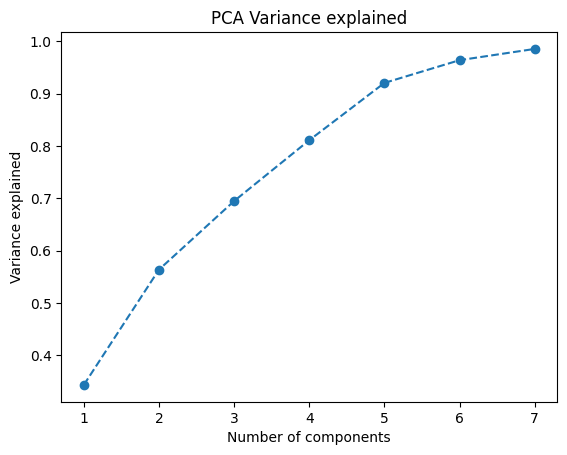

In [5]:
# Check which pca makes more sense
pca_variances = []

for n in range(1, len(numerical_features)):
    pca = PCA(n_components=n)
    pca.fit(data[numerical_features])
    pca_variances.append(pca.explained_variance_ratio_.sum())   

plt.plot(range(1, len(numerical_features)), pca_variances, marker='o', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')
plt.title('PCA Variance explained')
plt.show()

In [6]:
# Lets keep 3 components, as it explains already 70% of the variance
pca = PCA(n_components=3)
pca_features = pca.fit_transform(data[numerical_features])
pca_features = pd.DataFrame(pca_features, columns=['pca_1', 'pca_2', 'pca_3'])

data = pd.concat([data, pca_features], axis=1)

#### __Outlier Detection and Removal__

## __2. Clustering Models - Simple__

### 2.1. K-Means Clustering (stochastic)
- **n_clusters**: The number of clusters to form.
- **init**: Method for initialization, like 'k-means++' or random.
- **n_init**: Number of times the algorithm will run with different centroid seeds.

### 2.2. DBSCAN (mostly deterministic)
- **eps**: The maximum distance between two samples for one to be considered in the neighborhood of the other.
- **min_samples**: The number of samples in a neighborhood for a point to be considered a core point.

### 2.3. Mean Shift (Deterministic)
- **bandwidth**: Sets the size of the area (radius) around each data point to search for other data points. If not given, the bandwidth is estimated.
- **bin_seeding**: If true, initial kernel locations are not locations of all points, but rather the discretized version, leading to faster convergence.

### 2.4. Gaussian Mixture Models (stochastic)
- **n_components**: The number of mixture components (clusters).
- **covariance_type**: The type of covariance parameters to use (e.g., 'full', 'tied', 'diag', 'spherical').
- **init_params**: The method used for initialization (e.g., 'kmeans', 'random').

### 2.5. Results 
______________________________________________________________________

### __FUNCTIONS__

In [7]:
def calculate_r2(data, centroids, detailed=False):
    # R2 = 1 - (SSB/SST), where SSB is the sum of squares between the clusters and SST is the total sum of squares. SST = SSB + SSW, where SSW is the sum of squares within the clusters.
    # Calculate SST
    if data.columns.str.startswith('b_').any() or data.columns.str.startswith('c_').any():
        raise Exception('Data contains categorical or binary features. Please remove them before calculating R2.')
    if not data.columns.str.contains('cluster').any():
        raise Exception('Data does not contain cluster column. Please run KMeans first.')

    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    X = data.drop('cluster', axis=1)
    sst = get_ss(X)

    # Calculate SSW
    ssw = data.groupby('cluster').apply(get_ss).sum()

    # Calculate SSB
    ssb = sst - ssw
    
    if detailed:
        return {'sst': sst, 'ssw': ssw, 'ssb': ssb, 'r2': 1 - (ssb/sst)}
    else:
        return 1 - (ssb/sst)

In [8]:
def random_search (X, model, params_dict, n_iter=100, verbose=False, return_scores=False) : 
    best_score = 0
    best_params, silhouette_scores, r2_scores = {}, {}, {}
    for i in range(n_iter) : 
        params = {}

        # Generate the random parameters
        for param in params_dict : 
            params[param] = np.random.choice(params_dict[param])
        model.set_params(**params, n_jobs=-1)
        labels = model.fit_predict(X)

        # Predict labels
        X_ = pd.concat([X, pd.DataFrame(labels, columns=['cluster'])], axis=1)

        # Get centroids manually 
        centroids = pd.DataFrame.groupby(X_, 'cluster').mean().values

        # Calculate the scores - for the selection of the best parameters we will use the silhouette score
        score = silhouette_score(X, model.labels_)
        r2 = calculate_r2(X_, centroids)
        silhouette_scores[str(params)] = score
        r2_scores[str(params)] = r2

        # Update the best score and params
        if score > best_score : 
            best_score = score
            best_params = params

        # Count how many clusters we have
        clusters = Counter(labels)

        print(f'Iteration {i+1} - Params: {params} - Score: {score:.4f} - Best Score: {best_score:.4f} - Clusters: {clusters}') if verbose else None

    if return_scores : 
        return best_score, best_params, silhouette_scores, r2_scores
    else :
        return best_score, best_params

In [132]:
def display_clustering(X, clusters, title=None, figsize=(10, 5)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    # PCA Plot 
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(X[numerical_features])
    pca_features = pd.DataFrame(pca_features, columns=['pca_1', 'pca_2'])
    colors = cm.nipy_spectral(clusters.astype(float) / clusters.max())
    axs[0].scatter(pca_features['pca_1'], pca_features['pca_2'], marker=".", s=12, lw=0, alpha=0.8, c=colors, edgecolor="k")

    # Plot the centroids
    pca_features['cluster'] = clusters
    centroids = pca_features.groupby('cluster').mean().values
    axs[0].scatter(centroids[:,0],centroids[:,1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
    for centroid, i in zip(centroids, range(len(centroids))):
        axs[0].scatter(centroid[0], centroid[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    axs[0].set_title("PCA plot for the various clusters.")
    axs[0].set_xlabel("Feature space for the 1st feature")
    axs[0].set_ylabel("Feature space for the 2nd feature")

    # Add the UMAP plot ------------------------------------------------------------------------------------
    reducer = UMAP(n_neighbors=100)
    embedding = reducer.fit_transform(X[numerical_features])
    colors = cm.nipy_spectral(clusters.astype(float) / clusters.max())
    axs[1].scatter(embedding[:, 0], embedding[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    axs[1].set_title("UMAP plot for the various clusters.")
    axs[1].set_xlabel("Feature space for the 1st feature")
    axs[1].set_ylabel("Feature space for the 2nd feature")

    if title:
        plt.suptitle(title, fontsize=14, fontweight="bold")

    plt.show()

### 2.1 K-Means Clustering
We will use the K-Means Clustering algorithm with init='k-means++' and n_init=10, as it is standard and won't change too much the results. To find the optimal number of clusters, we have:
- 2.1.1. Evaluating n_clusters: K-Means Clustering - Elbow Method
- 2.1.2. K-Means Clustering - Silhouette Score

Results:
- 5 clusters seems like a strech. We will use 4 clusters.
- Good results for 4 clusters
______________________________________________________________________

#### 2.1.1. Evaluating n_clusters: K-Means Clustering - Elbow Method

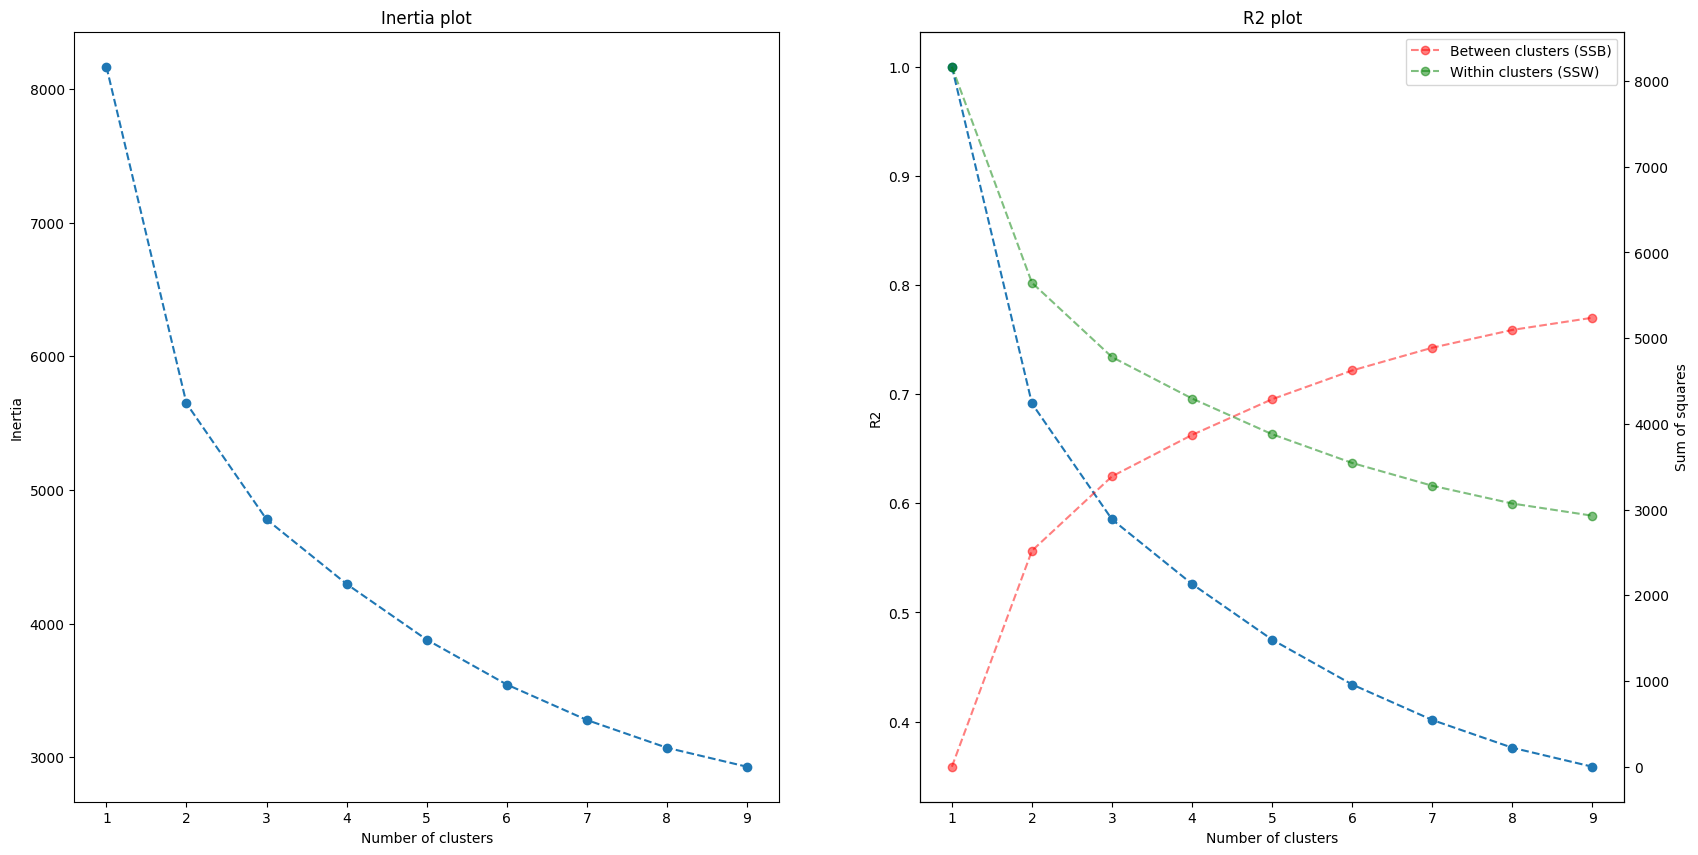

In [181]:
inertia, r2, sst, ssb, ssw = [], [], [], [], []
range_values = range(1, 10)  # Adjust this range based on your dataset

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range_values:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10)
    kmeans.fit(data[numerical_features])

    # Calculate inertia
    inertia.append(kmeans.inertia_)

    # Calculate R2
    labels = pd.DataFrame(kmeans.labels_, columns=['cluster'])
    X = pd.concat([data[numerical_features], labels], axis=1)
    results = calculate_r2(X, kmeans.cluster_centers_, detailed=True)
    r2.append(results['r2'])
    sst.append(results['sst'])
    ssb.append(results['ssb'])
    ssw.append(results['ssw'])


# Plot the results
axs[0].plot(range_values, inertia, marker='o', linestyle='--')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Inertia')
axs[0].set_title('Inertia plot')

axs[1].plot(range_values, r2, marker='o', linestyle='--', label='R2')

# Change axis of the second plot
axs2 = axs[1].twinx()
axs2.plot(range_values, ssb, marker='o', linestyle='--', color='red', label='Between clusters (SSB)', alpha=0.5)
axs2.plot(range_values, ssw, marker='o', linestyle='--', color='green', label='Within clusters (SSW)', alpha=0.5)
axs2.set_ylabel('Sum of squares')
axs2.legend(loc='best')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('R2')
axs[1].set_title('R2 plot')

plt.show()

Based on the elbow method, we would select 2-3 clusters. With the R2 plot, where 0.5 is an ideal value, we can see that 2-4 clusters would be good.

#### 2.1.2. Evaluating n_clusters: K-Means Clustering - Silhouette Score

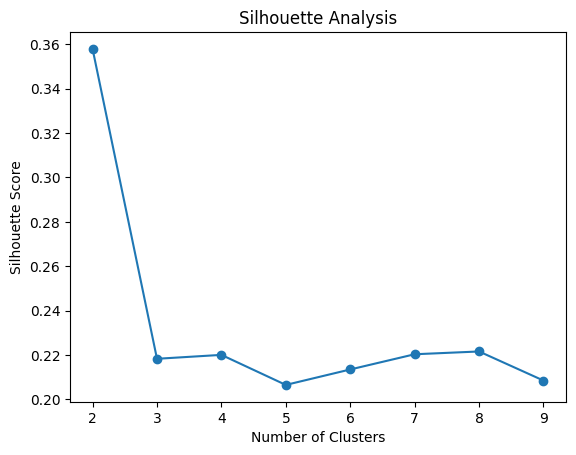

In [76]:
silhouette_scores = []

for i in range_values:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10)
    kmeans_clusters = kmeans.fit_predict(data[numerical_features])
    score = silhouette_score(data[numerical_features], kmeans_clusters)
    silhouette_scores.append(score)

plt.plot(range_values, silhouette_scores, 'o-')
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3579178560090086
For n_clusters = 3 The average silhouette_score is : 0.3267482993426435
For n_clusters = 4 The average silhouette_score is : 0.22021496562772144
For n_clusters = 5 The average silhouette_score is : 0.20800767423253377


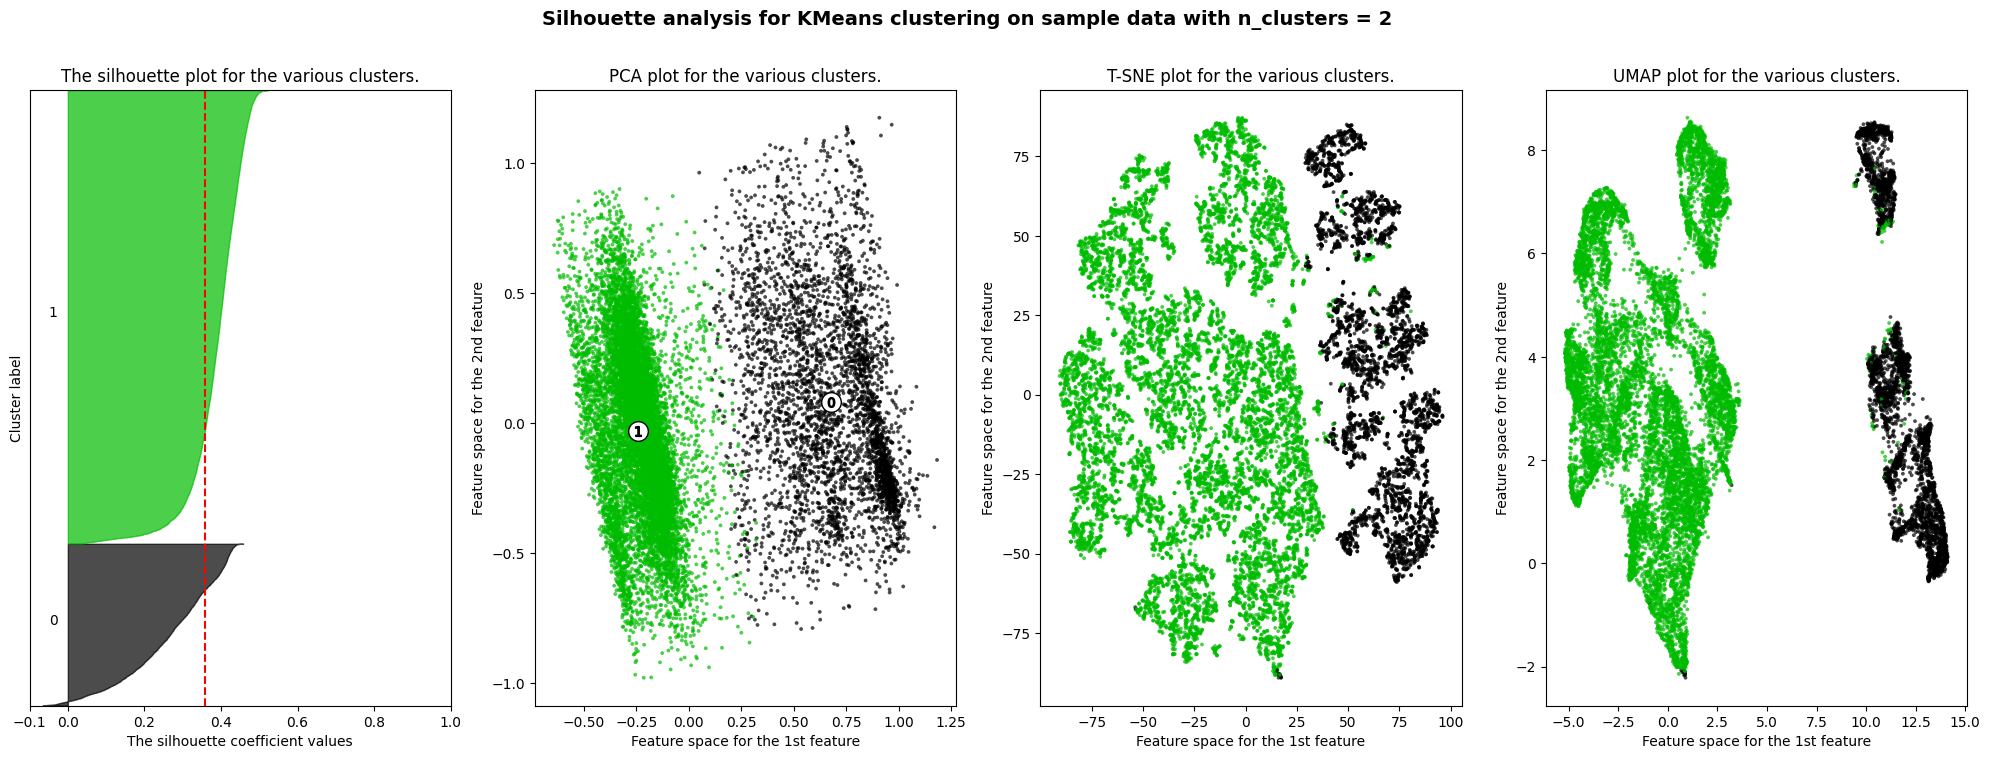

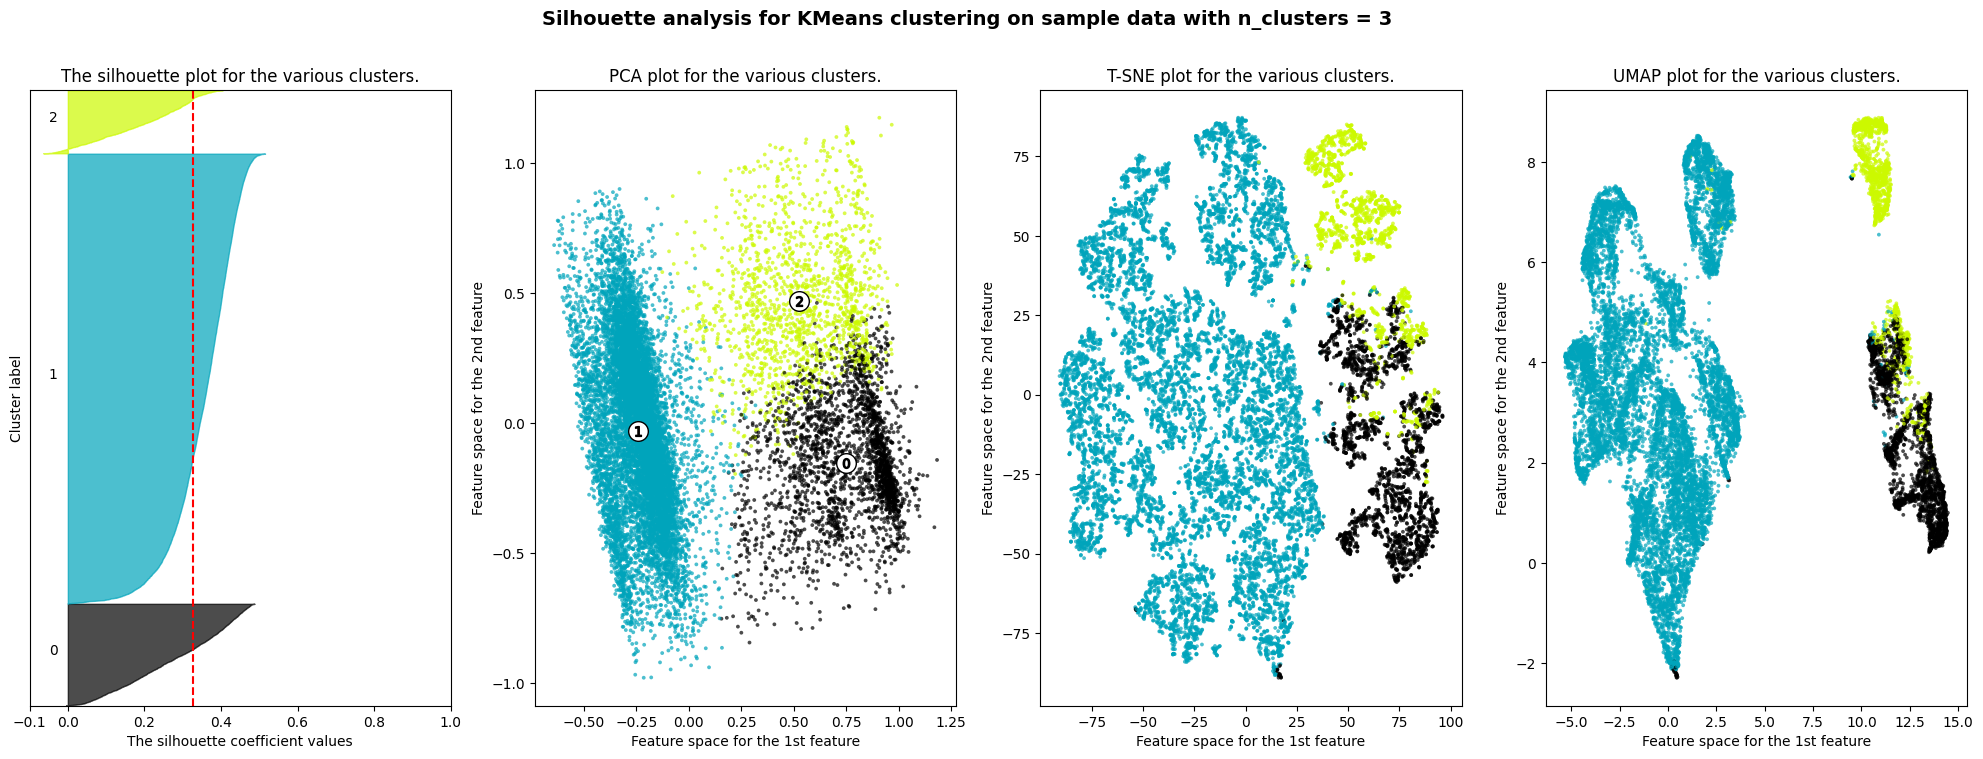

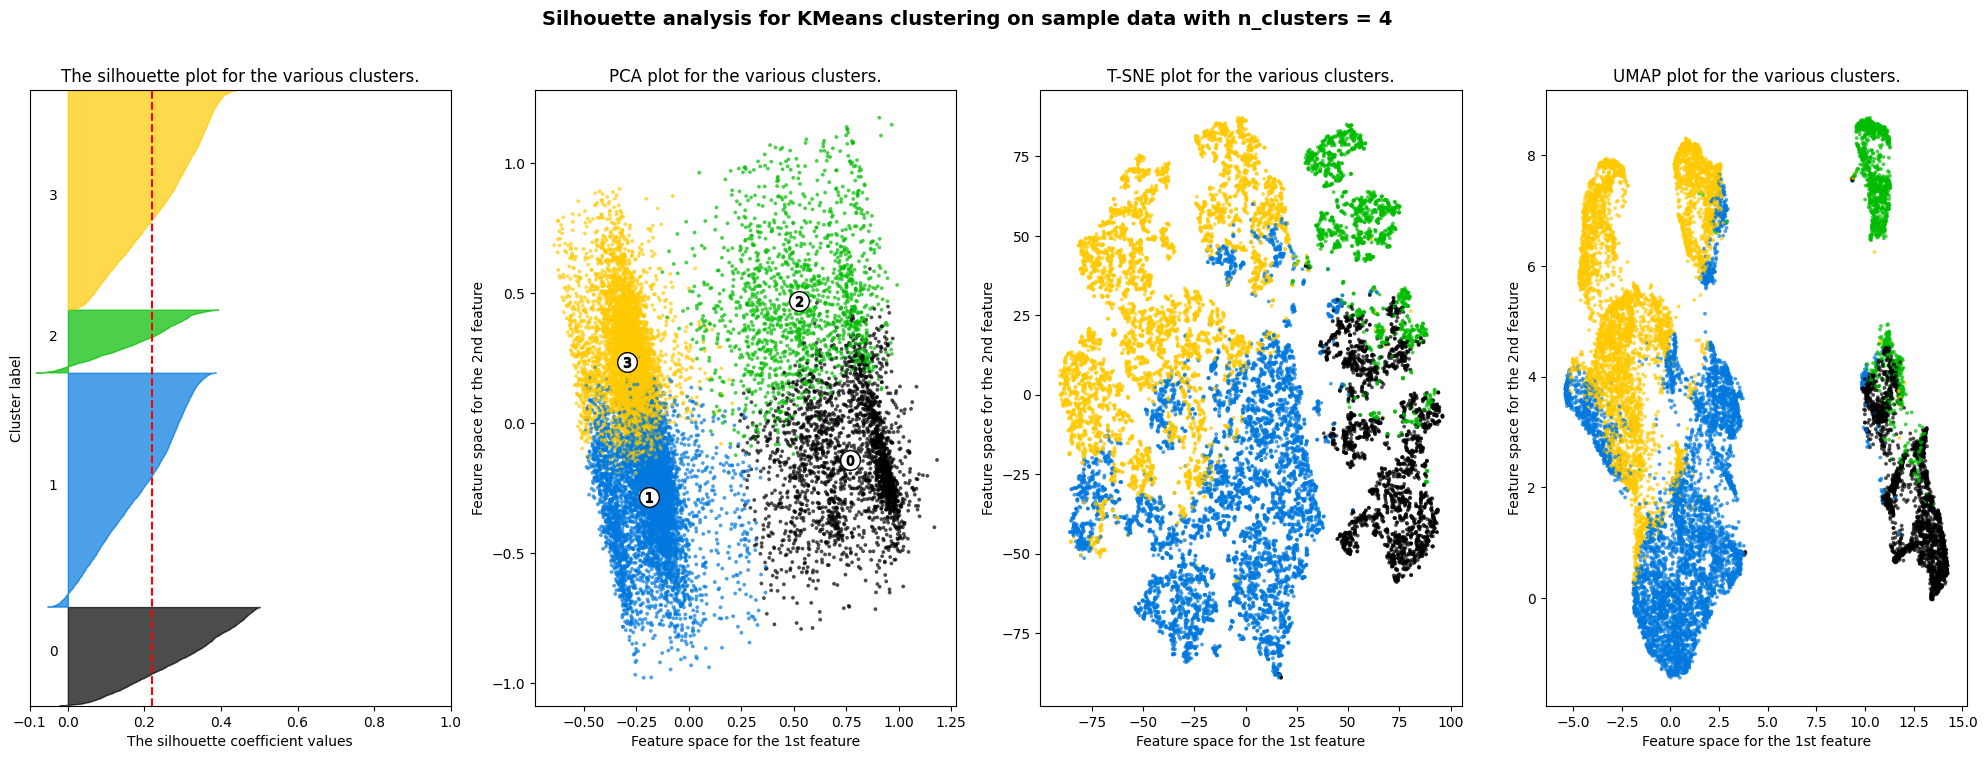

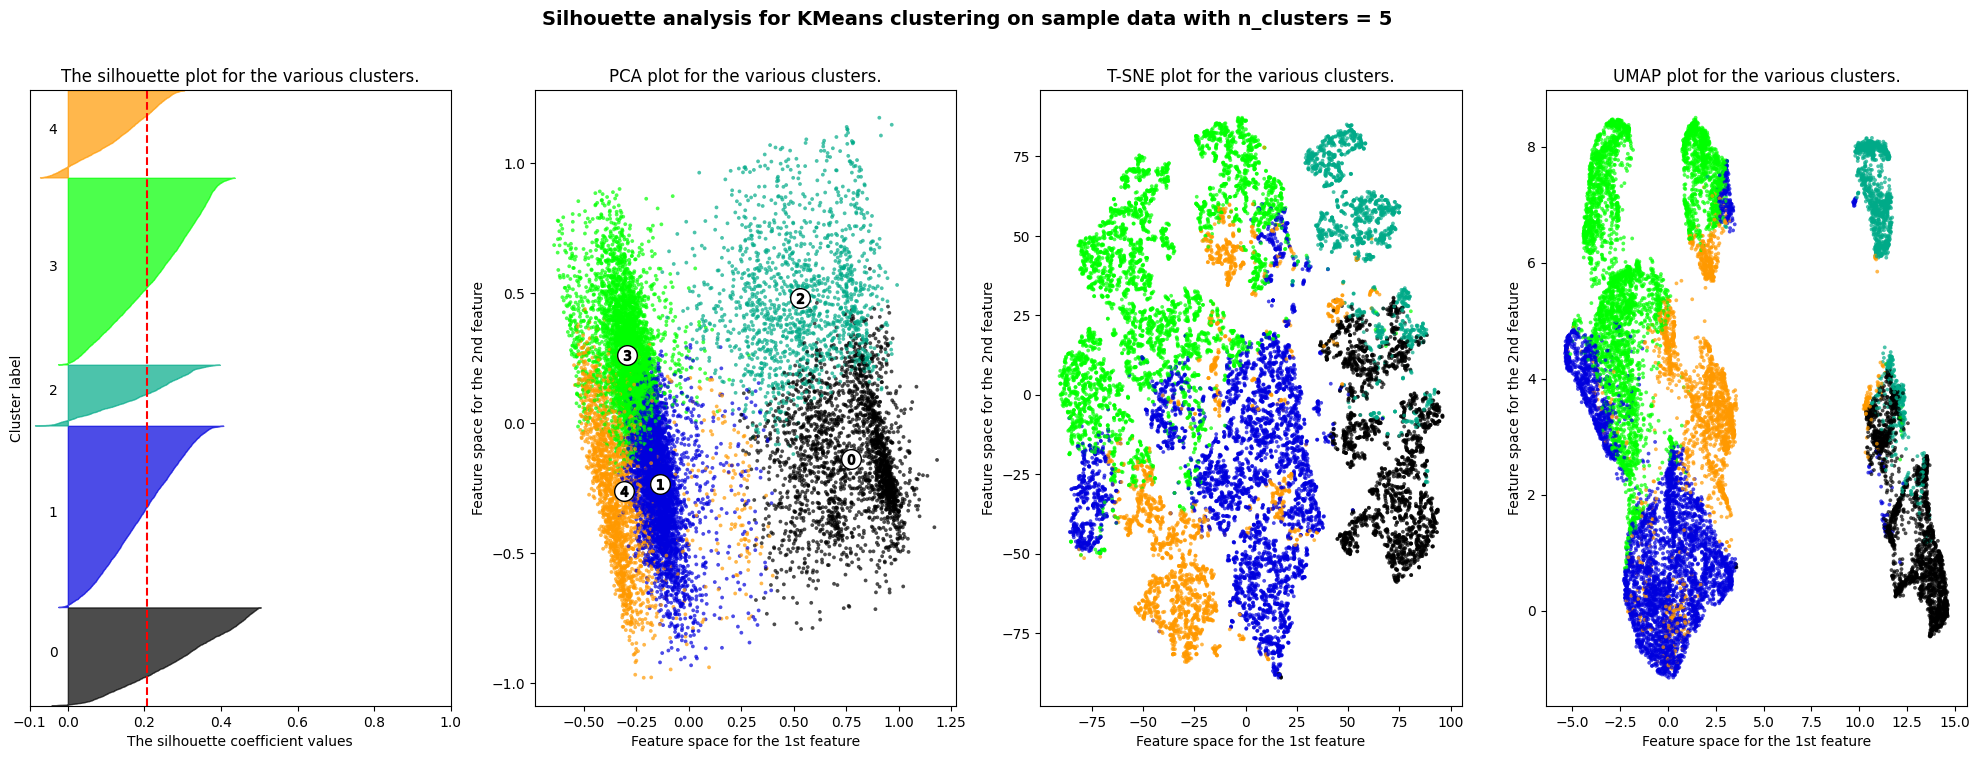

In [107]:
X = data[numerical_features]
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Initialize the plot with the specified dimensions.
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(25, 8)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer and predict clusters
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
    # Create the silhouette plot
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)

        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # Plot the pca components ------------------------------------------------------------------------------------
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(X)
    pca_features = pd.DataFrame(pca_features, columns=['pca_1', 'pca_2'])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pca_features['pca_1'], pca_features['pca_2'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    # Plot the centroids as well
    # Plot the centroids
    pca_features['cluster'] = cluster_labels
    centroids = pca_features.groupby('cluster').mean().values
    ax2.scatter(centroids[:,0],centroids[:,1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
    for centroid, i in zip(centroids, range(len(centroids))):
        ax2.scatter(centroid[0], centroid[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("PCA plot for the various clusters.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")


    # Now for the 2nd plot - the visualization ------------------------------------------------------------------------------------
    tsne = TSNE(n_components=2)  # number of dimensions to project to
    X_tsne = tsne.fit_transform(X) 

    # For the samples 
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    ax3.set_title("T-SNE plot for the various clusters.")
    ax3.set_xlabel("Feature space for the 1st feature")
    ax3.set_ylabel("Feature space for the 2nd feature")

    # Add the UMAP plot ------------------------------------------------------------------------------------
    reducer = UMAP(n_neighbors=100)
    embedding = reducer.fit_transform(X)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax4.scatter(embedding[:, 0], embedding[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    ax4.set_title("UMAP plot for the various clusters.")
    ax4.set_xlabel("Feature space for the 1st feature")
    ax4.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters), fontsize=14, fontweight="bold")

plt.show()


- From looking at all this data, 5 seems a little out of reach for now. We would consider 3-4 clusters.
- Lets try now 4 clusters and see how th results look like.

In [110]:
# Cluster the data with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=50)
kmeans_clusters = kmeans.fit_predict(data[numerical_features])
data['cluster'] = kmeans_clusters

# Check how the clusters are distributed
clusters = Counter(kmeans_clusters)
print(clusters)
data[numerical_features+binary_features+['cluster']].groupby('cluster').mean().T.style.background_gradient(axis=1)

Counter({2: 5605, 1: 5419, 0: 2405, 3: 1512})


#### Data to display:

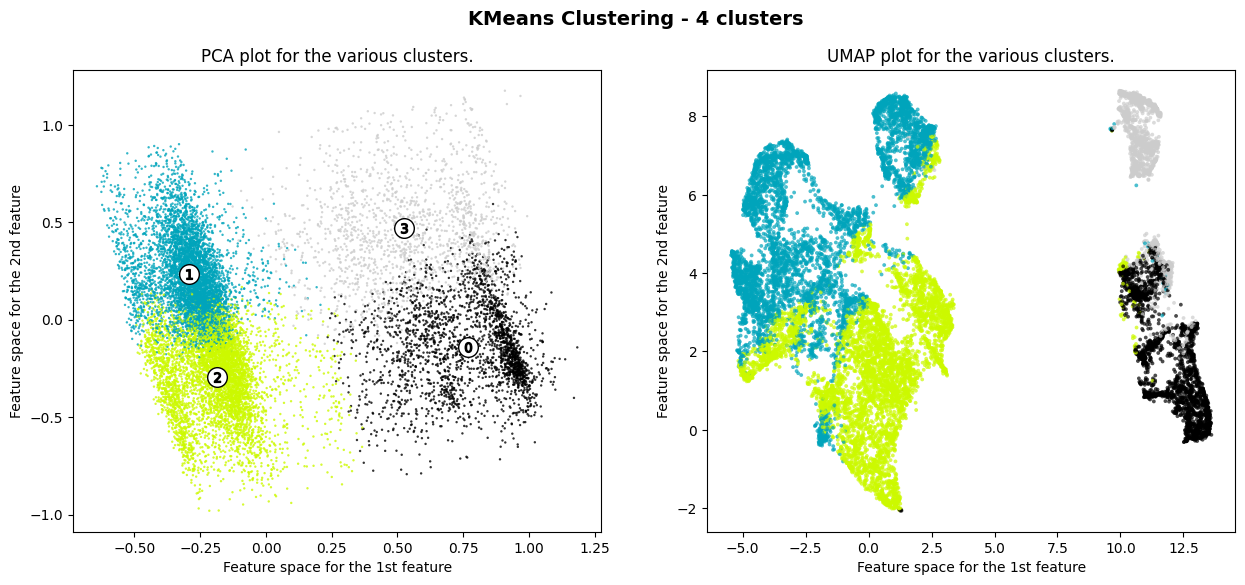

In [135]:
display_clustering(data, kmeans_clusters, title='KMeans Clustering - 4 clusters', figsize=(15,6))

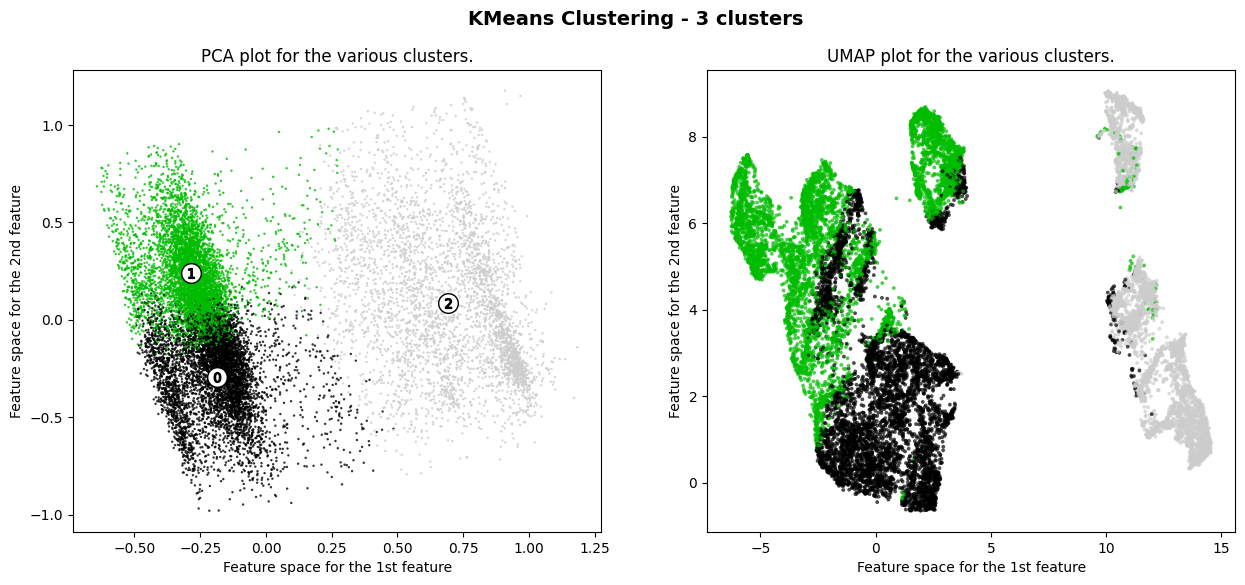

In [138]:
# Cluster the data with 4 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=50)
kmeans_clusters = kmeans.fit_predict(data[numerical_features])
data['cluster'] = kmeans_clusters

display_clustering(data, kmeans_clusters, title='KMeans Clustering - 3 clusters', figsize=(15,6))

### 2.2. DBSCAN (mostly deterministic)
We only have to change the epsilon and min_samples parameters. We will use the default values for the rest of the parameters.
- 2.2.1. Evaluating eps: DBSCAN - Elbow Method on the k-dist graph with fixed min_samples (usually 2*dim is a good starting point). The plot is made with the n_neighbors parameter set to k=min_pts - 1
- 2.2.2. Evaluating min_samples and eps: DBSCAN - Random Search

Results : 
- 3 clusters with params 'eps': 0.294, 'min_samples': 17
- K-Means clustering seems to be better 
______________________________________________________________________

#### 2.2.1 Evaluating eps: DBSCAN - Elbow Method on the k-dist graph with fixed min_samples (usually 2*dim is a good starting point)

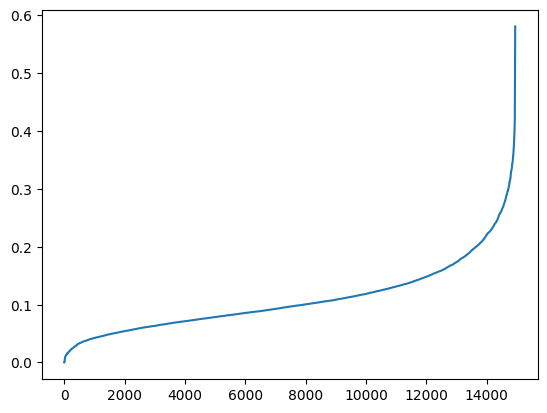

In [17]:
# Plot the k-dist plot
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=16)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Lets start with an epsilon of 0.25. What are the results?

In [82]:
dbscan = DBSCAN(eps=0.25, min_samples=15)
clusters = dbscan.fit_predict(X)

Counter(clusters)

Counter({-1: 1892,
         0: 10514,
         2: 1895,
         1: 458,
         3: 123,
         8: 14,
         7: 16,
         6: 7,
         4: 4,
         5: 18})

In [93]:
cluste

{'algorithm': 'auto',
 'eps': 0.25,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 15,
 'n_jobs': None,
 'p': None}

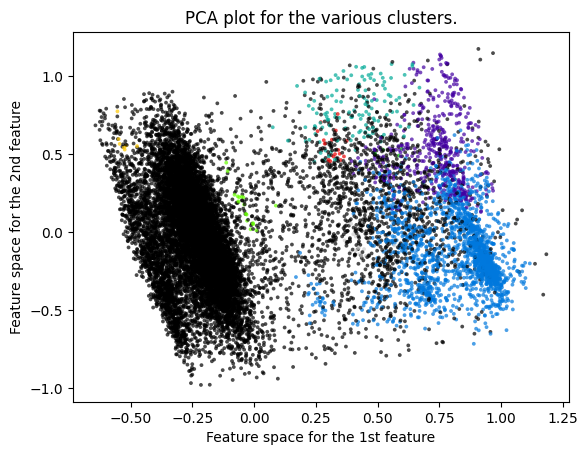

In [83]:
# Plot the clusters
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)
pca_features = pd.DataFrame(pca_features, columns=['pca_1', 'pca_2'])
colors = cm.nipy_spectral(clusters.astype(float) / clusters.max())
plt.scatter(pca_features['pca_1'], pca_features['pca_2'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
plt.title("PCA plot for the various clusters.")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

Not good. Lets move on to step 2

#### 2.2.2. Evaluating min_samples and eps: DBSCAN - Random Search
- Lets set up a random search for min samples and the epsilon value

In [ ]:
X = data[numerical_features]

params_dict = {
    'eps': [val / 3000 for val in range(300, 900)],  # From 0.1 to 0.3, now from 0.3 to 0.4
    'min_samples': [val for val in range(1, 50)]
}

best_score, best_params, silhouettes, r2 = random_search(X, DBSCAN(), params_dict, n_iter=200, verbose=True, return_scores=True)

silhouette_scores = pd.DataFrame.from_dict(silhouettes, orient='index', columns=['score'])
silhouette_scores.reset_index(level=0, inplace=True)

# Rename the new column
silhouette_scores = silhouette_scores.rename(columns={'index': 'parameters'})

# Convert the 'parameters' column into a DataFrame and concatenate it with 'score'
silhouette_scores = pd.concat([silhouette_scores['parameters'].apply(pd.Series), silhouette_scores['score']], axis=1)

silhouette_scores['eps'] = silhouette_scores.apply(lambda row: row[0].split(',')[0].split(':')[1], axis=1)
silhouette_scores['min_samples'] = silhouette_scores.apply(lambda row: row[0].split(',')[1].split(':')[1].split('}')[0], axis=1)
silhouette_scores.drop(0, axis=1, inplace=True)

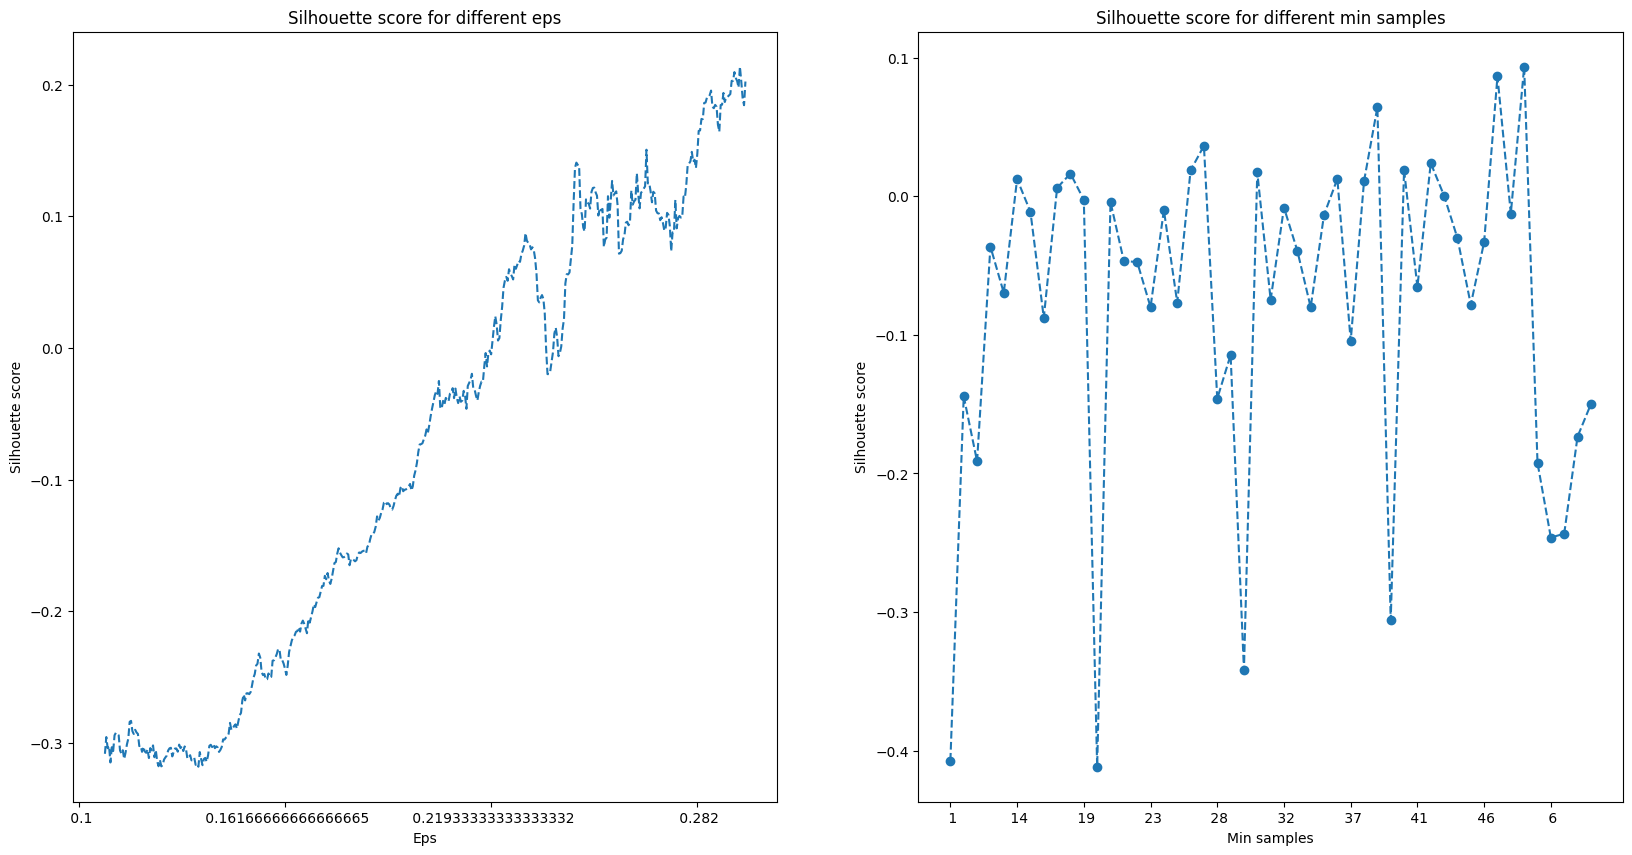

In [95]:
# Plot how the silhouette score changes with the parameters
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
eps = silhouette_scores.groupby('eps').mean(numeric_only=True).rolling(20).mean().sort_index()
min_samples = silhouette_scores.groupby('min_samples').mean(numeric_only=True).sort_index()

axs[0].plot(eps.index, eps['score'], linestyle='--')
axs[0].set_xlabel('Eps')
axs[0].set_ylabel('Silhouette score')
axs[0].set_title('Silhouette score for different eps')
axs[0].set_xticks(eps.index[::150])

axs[1].plot(min_samples.index, min_samples['score'], marker='o', linestyle='--')
axs[1].set_xlabel('Min samples')
axs[1].set_ylabel('Silhouette score')
axs[1].set_title('Silhouette score for different min samples')
# Change the xticks so that there are less of them
axs[1].set_xticks(min_samples.index[::5])

plt.show()

In [140]:
# Run the model with the best parameters
X = data[numerical_features]
best_params = {'eps': 0.294, 'min_samples': 17}
dbscan = DBSCAN(**best_params)
dbscan_clusters = dbscan.fit_predict(X)

Counter(dbscan_clusters)

Counter({-1: 1081, 0: 10720, 1: 2338, 2: 802})

##### What are the main differences in features between the clusters?

In [105]:
X = data.copy()
X['cluster'] = dbscan_clusters 
X[binary_features + numerical_features + ['cluster']].groupby('cluster').mean(numeric_only=True).T.style.background_gradient(axis=1)

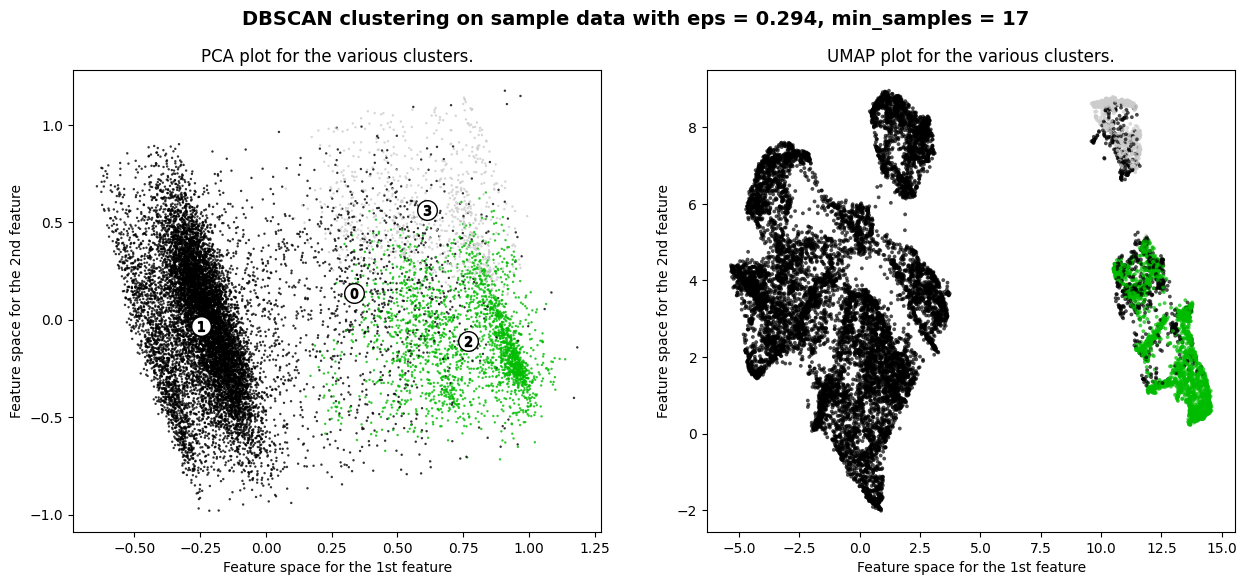

In [142]:
display_clustering(X, dbscan_clusters, title="DBSCAN clustering on sample data with eps = {}, min_samples = {}".format(best_params['eps'], best_params['min_samples']), figsize=(15,6))

### 2.3. Mean Shift (Deterministic)
- 2.3.1. Using the estimate bandwidth function to find the optimal bandwidth, always with bin seeding set to True

Results:
- 4 clusters with parameters bandwidth=0.5663, bin_seeding=True. The results are not the best.
______________________________________________________________________

#### 2.3.1. Using the estimate bandwidth function to find the optimal bandwidth 
##### General Rule:

- A lower quantile (e.g., 0.1 to 0.3) results in a smaller bandwidth, leading to more clusters with finer granularity.
- A higher quantile (e.g., 0.4 to 0.9) results in a larger bandwidth, leading to fewer, larger clusters.

##### Data Density and Size:

- For dense datasets or those with many points, a smaller quantile can be more appropriate, as it allows for finer distinctions between clusters.
- For sparse datasets or those with fewer points, a higher quantile might be better to avoid over-segmentation.

In [ ]:
range_quantiles = [val / 250 for val in range(1, 80)]
bandwidths, sil_scores, r2_scores = [], [], []

for quantile in range_quantiles:
    bandwidth = estimate_bandwidth(data[numerical_features], quantile=quantile, n_jobs=-1)
    bandwidths.append(bandwidth)

    # Fit the model 
    meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
    clusters = meanshift.fit_predict(data[numerical_features])

    # Calculate scores
    score = silhouette_score(data[numerical_features], clusters)
    labels = pd.DataFrame(clusters, columns=['cluster'])
    X = pd.concat([data[numerical_features], labels], axis=1)
    r2 = calculate_r2(X, meanshift.cluster_centers_)
    sil_scores.append(score)
    r2_scores.append(r2)

    # Calculate the number of clusters
    clusters = Counter(clusters)
    print(f'Quantile: {quantile} - Bandwidth: {bandwidth:.4f} - Silhouette score: {score:.4f} - R2: {r2:.4f} - Clusters: {clusters}')

This is our best score:

Quantile: 0.08 - Bandwidth: 0.5663 - Silhouette score: 0.2660 - R2: 0.6708 - Clusters: Counter({0: 11109, 1: 3277, 2: 325, 3: 230})


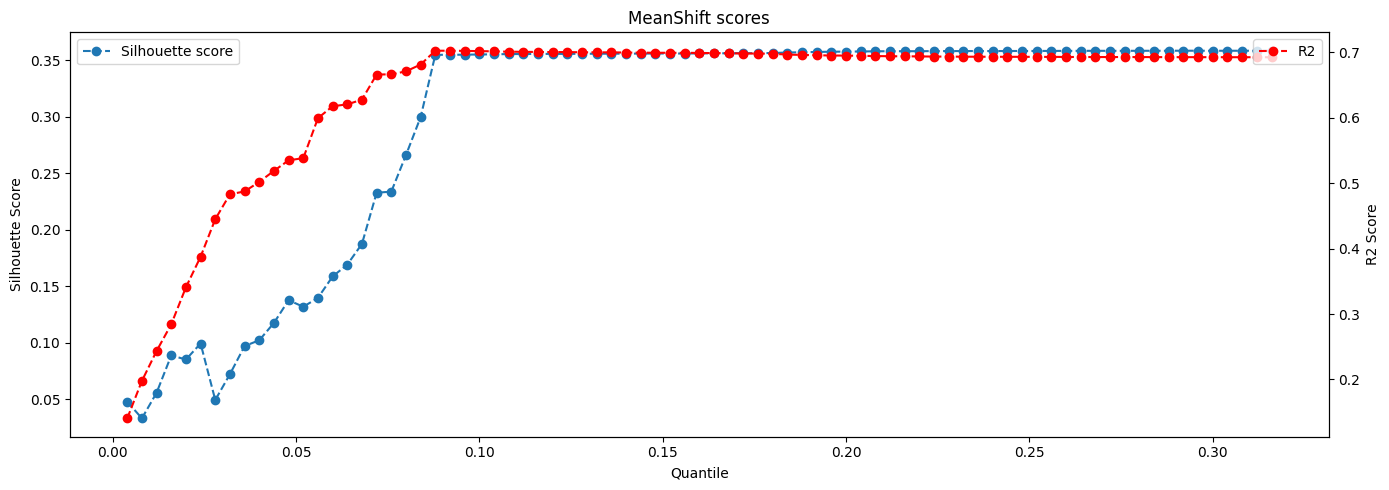

In [29]:
# Get the data frame with the results
ms_param_stats = pd.DataFrame({'quantile': range_quantiles, 'bandwidth': bandwidths, 'silhouette_score': sil_scores, 'r2': r2_scores})

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(range_quantiles, sil_scores, marker='o', linestyle='--', label='Silhouette score')
plt.xlabel('Quantile')
plt.ylabel('Silhouette Score')
plt.legend(loc='upper left')
ax2 = plt.twinx()
ax2.plot(range_quantiles, r2_scores, marker='o', linestyle='--', color='red', label='R2')
plt.xlabel('Quantile')
plt.ylabel('R2 Score')
plt.title('MeanShift scores')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [32]:
# Meanshift clustering
X = data.copy()
meanshift = MeanShift(bandwidth=0.5663, n_jobs=-1)
meanshift_clusters = meanshift.fit_predict(X[numerical_features])
X['cluster'] = meanshift_clusters

# Check how the clusters are distributed
clusters = Counter(meanshift_clusters)
print(clusters)

Counter({0: 11109, 1: 3277, 2: 325, 3: 230})


##### Lets see our result

In [36]:
X[numerical_features+binary_features+['cluster', 'drop_n_age']].groupby('cluster').mean().T.style.background_gradient(axis=1)

##### Graphically

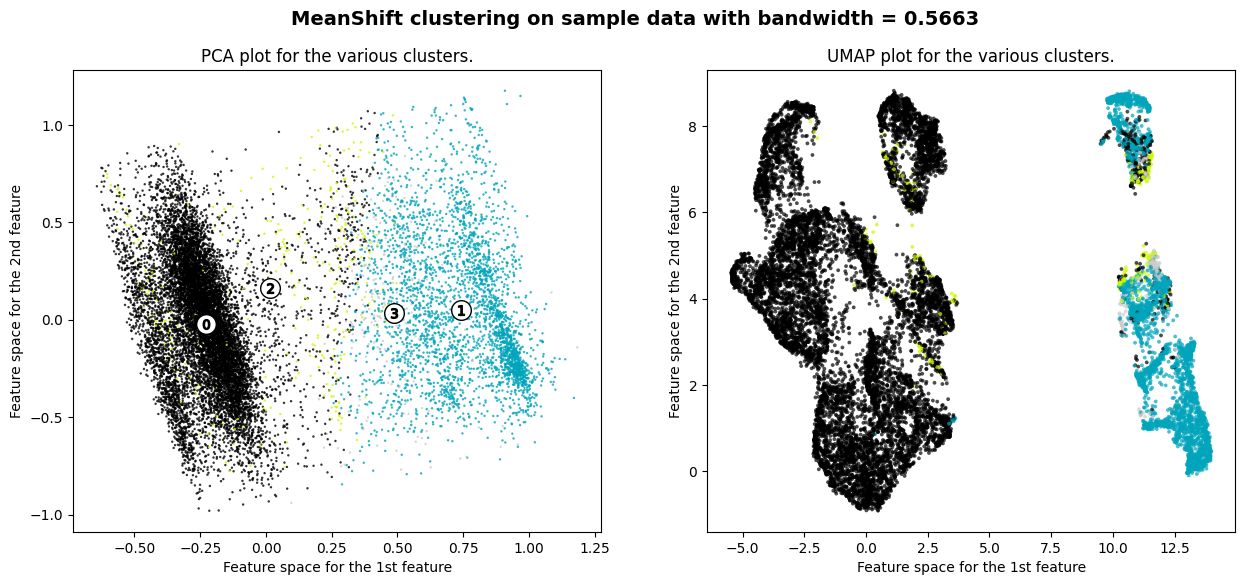

In [133]:
display_clustering(X, meanshift_clusters, title="MeanShift clustering on sample data with bandwidth = 0.5663", figsize=(15, 6))

Cluster 2 is clearly not good. The problem is that we have a change in density in the data. And between clusters 0 and 1, we have a low density.

### 2.4. Gaussian Mixture Models (stochastic)
- 2.4.1. Using AIC and BIC to determine the n_components
- 2.4.2. Testing the covariance type (make a table with the time waited) -> 'full', 'tied', 'diag', 'spherical'
- 2.4.3. Testing the init_params parameter -> 'kmeans', 'random', 'k-means++', 'random_from_data'
- 2.4.4. Checking which number of components is best (from what the AIC and BIC said).
______________________________________________________________________

#### 2.4.1. Method: AIC/BIC Approach:
- BIC/AIC can be particularly useful as it balances model complexity with goodness of fit.
- Calculate BIC/AIC for a range of n_components and choose the one with the lowest BIC/AIC value.

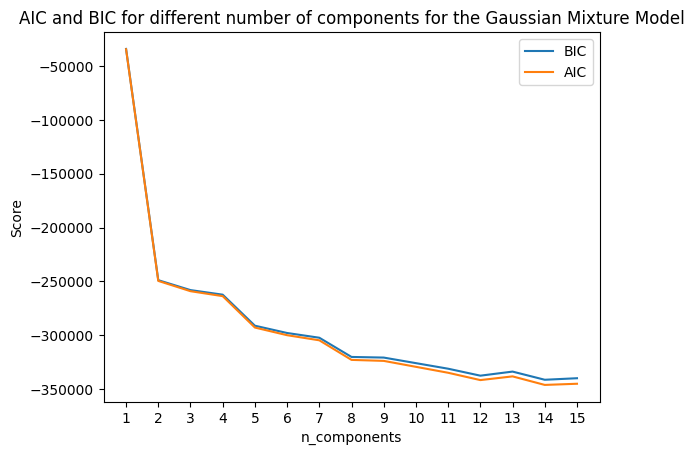

In [54]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(data[numerical_features])
          for n in n_components]

bic_values = [m.bic(data[numerical_features]) for m in models]
aic_values = [m.aic(data[numerical_features]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.title('AIC and BIC for different number of components for the Gaussian Mixture Model')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Score') 
plt.xticks(n_components)
plt.show()

Well, 2 is the obviuous choice, as it is quite an elbow. But 3 and 4 are better options, based on our intuition and what is useful for the business. 5 could also be a good option. Lets check the results.

####  2.4.2. Testing the covariance type (make a table with the time waited) -> 'full', 'tied', 'diag', 'spherical'
- We will only use the BIC, as they are more or less equivalent. We will use the n_components=4, as it is the best option.

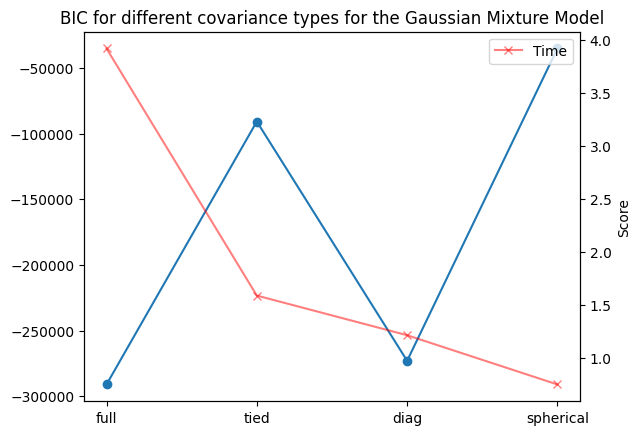

In [65]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

models, times = [], []

for covariance in covariance_type:
    start = time.time()
    model = GaussianMixture(5, covariance_type=covariance, n_init=10, random_state=1).fit(data[numerical_features])
    end = time.time()
    times.append(end - start)
    models.append(model)

bic_values = [m.bic(data[numerical_features]) for m in models]
plt.plot(covariance_type, bic_values, label='BIC', marker='o')
ax2 = plt.twinx()
ax2.plot(covariance_type, times, marker='x', color='red', label='Time', alpha=0.5)
ax2.set_ylabel('Time (s)')
plt.title('BIC for different covariance types for the Gaussian Mixture Model')
plt.legend(loc='best')
plt.xlabel('Covariance type')
plt.ylabel('Score')
plt.show()

Its clear that the best option is 'full'. Of course, it is the most computationally expensive, but our dataset is not that big.

#### 2.4.3. Testing the init_params parameter -> 'kmeans', 'random', 'k-means++', 'random_from_data'

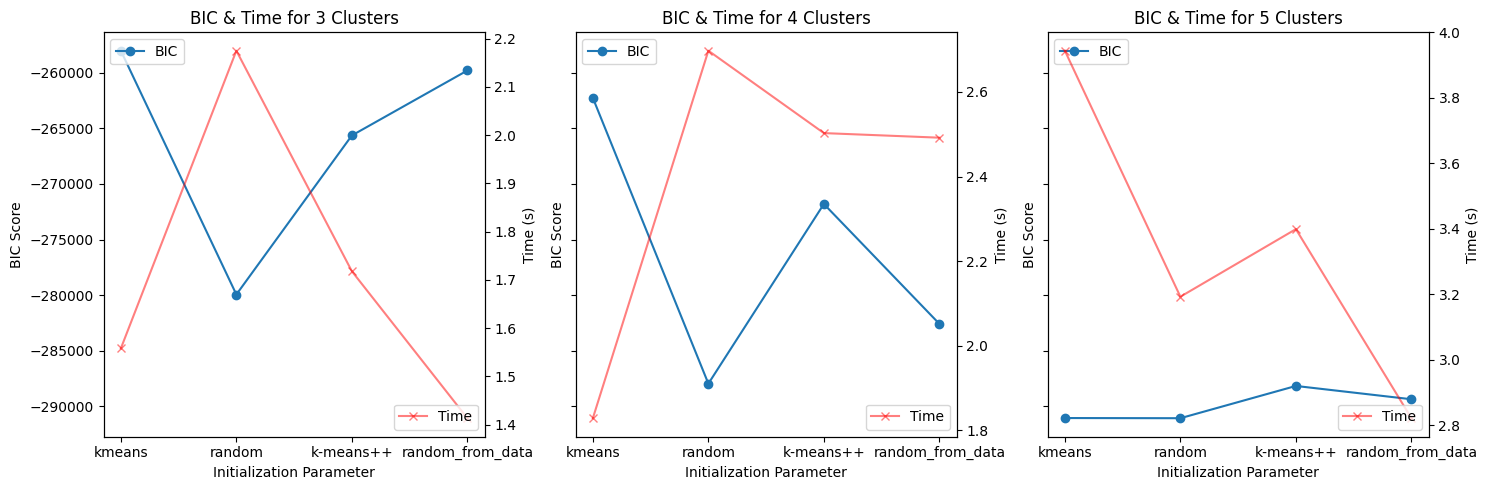

In [69]:
init_params = ['kmeans', 'random', 'k-means++', 'random_from_data']
cluster_numbers = [3, 4, 5]
models = {n: [] for n in cluster_numbers}
times = {n: [] for n in cluster_numbers}

for n_clusters in cluster_numbers:
    for init in init_params:
        start = time.time()
        model = GaussianMixture(n_clusters, covariance_type='full', n_init=10, init_params=init, random_state=1).fit(data[numerical_features])
        end = time.time()
        times[n_clusters].append(end - start)
        models[n_clusters].append(model)

fig, axs = plt.subplots(1, len(cluster_numbers), figsize=(15, 5), sharey=True)

for i, n_clusters in enumerate(cluster_numbers):
    bic_values = [m.bic(data[numerical_features]) for m in models[n_clusters]]
    axs[i].plot(init_params, bic_values, label='BIC', marker='o')
    ax2 = axs[i].twinx()
    ax2.plot(init_params, times[n_clusters], marker='x', color='red', label='Time', alpha=0.5)
    ax2.set_ylabel('Time (s)')
    axs[i].set_title(f'BIC & Time for {n_clusters} Clusters')
    axs[i].set_xlabel('Initialization Parameter')
    axs[i].set_ylabel('BIC Score')
    axs[i].legend(loc='upper left')
    ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()


We have a clear winner: 'random' is the best option. It is also one of the slower options, but its ok. We have a random state, so we can be sure that the results are not caused by randomness.

#### 2.4.4. Checking which number of components is best (from what the AIC and BIC said).

In [119]:
# Fit a Gaussian Mixture Model with 3,4 and 5 clusters
X = data[numerical_features].copy()
gmm3 = GaussianMixture(3, covariance_type='full', n_init=10, init_params='random', random_state=1).fit(X)
gmm4 = GaussianMixture(4, covariance_type='full', n_init=10, init_params='random', random_state=1).fit(X)
gmm5 = GaussianMixture(5, covariance_type='full', n_init=10, init_params='random', random_state=1).fit(X)

# Predict the clusters
gmm3_clusters = gmm3.predict(X)
gmm4_clusters = gmm4.predict(X)
gmm5_clusters = gmm5.predict(X)

# Add the clusters to the data
X['cluster_3'] = gmm3_clusters
X['cluster_4'] = gmm4_clusters
X['cluster_5'] = gmm5_clusters

# Check how the clusters are distributed
print(Counter(gmm3_clusters))
print(Counter(gmm4_clusters))
print(Counter(gmm5_clusters))

Counter({1: 10158, 0: 3312, 2: 1471})
Counter({0: 10139, 1: 2691, 2: 1471, 3: 640})
Counter({2: 10139, 4: 1711, 1: 1471, 0: 980, 3: 640})


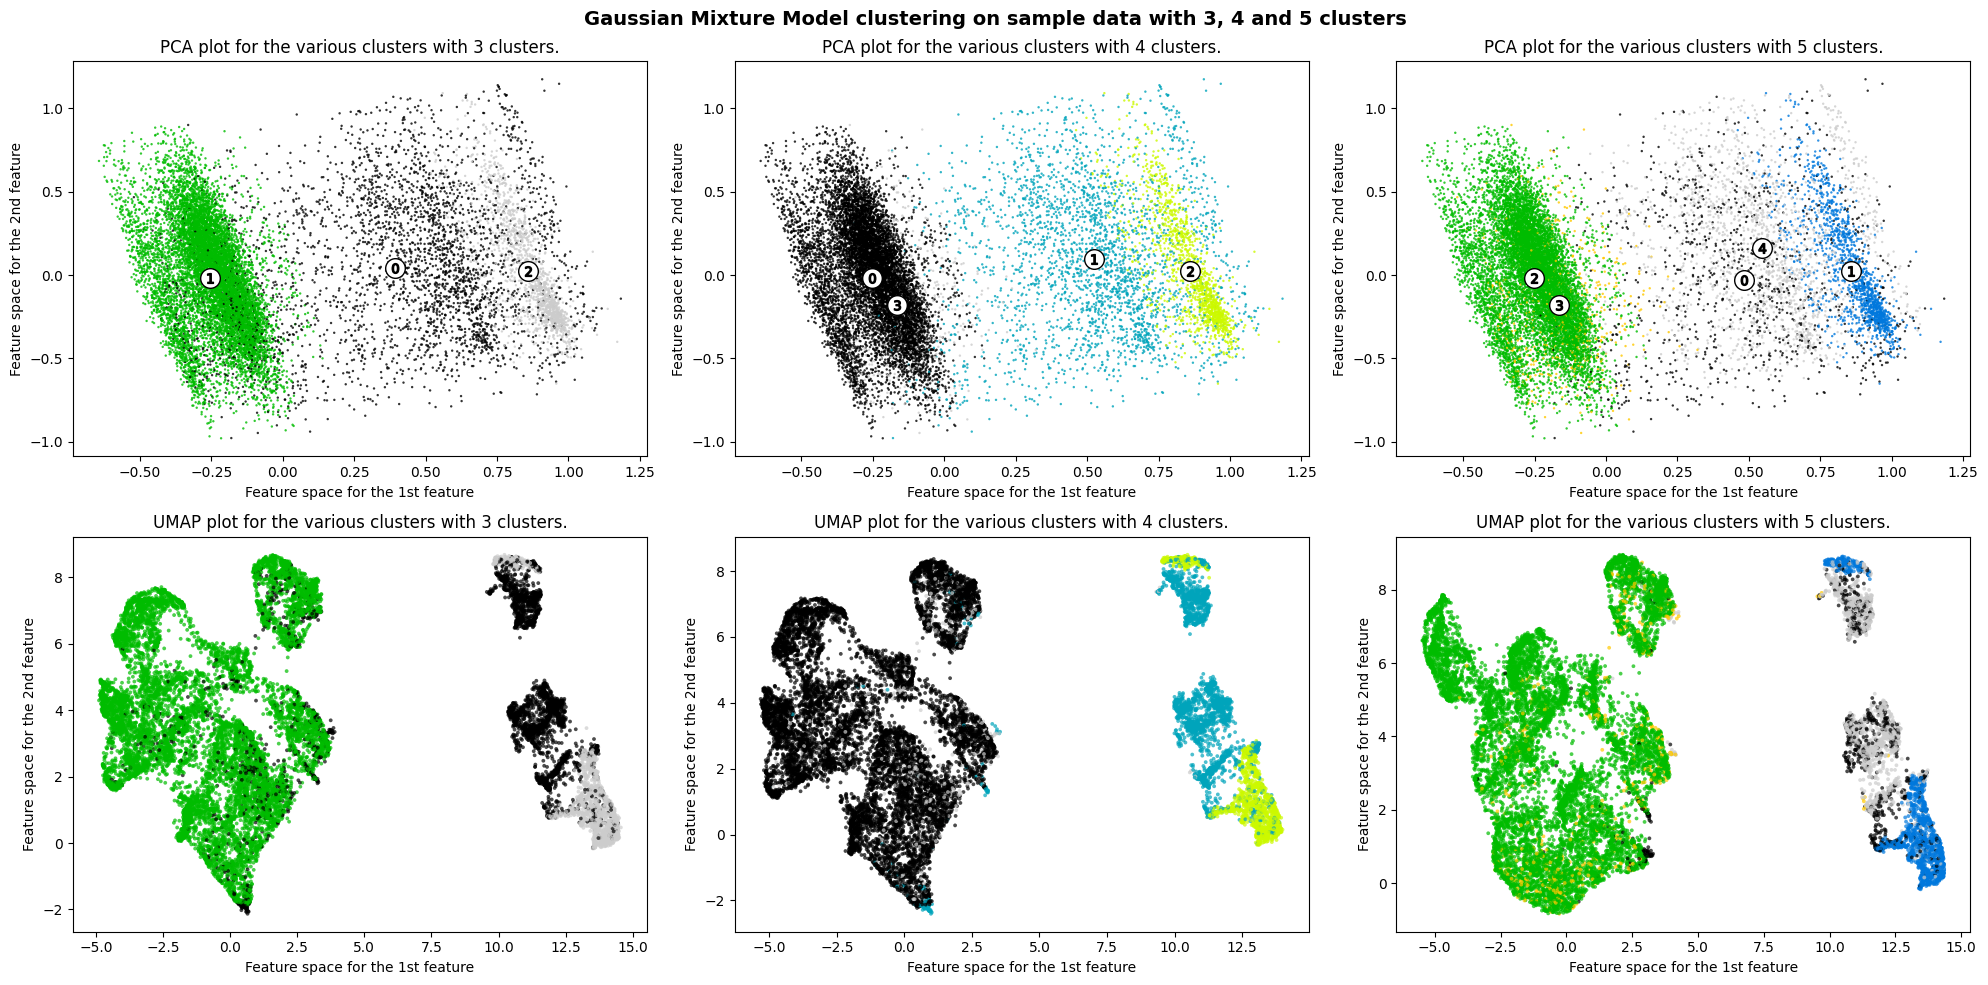

In [120]:
# Plot the clusters
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, cluster in enumerate(['cluster_3', 'cluster_4', 'cluster_5']):
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(X[numerical_features])
    pca_features = pd.DataFrame(pca_features, columns=['pca_1', 'pca_2'])
    colors = cm.nipy_spectral(X[cluster].astype(float) / X[cluster].max())
    
    axs[0][i].scatter(pca_features['pca_1'], pca_features['pca_2'], marker=".", s=12, lw=0, alpha=0.8, c=colors, edgecolor="k")
        
    # Add the cluster centers
    pca_features['cluster'] = X[cluster]
    centroids = pca_features.groupby('cluster').mean().values
    for centroid, j in zip(centroids, range(len(centroids))):
        axs[0][i].scatter(centroid[0],centroid[1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
        axs[0][i].scatter(centroid[0], centroid[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

    axs[0][i].set_title(f"PCA plot for the various clusters with {i+3} clusters.")
    axs[0][i].set_xlabel("Feature space for the 1st feature")
    axs[0][i].set_ylabel("Feature space for the 2nd feature")

    # Add the UMAP plot ------------------------------------------------------------------------------------
    reducer = UMAP(n_neighbors=100)
    embedding = reducer.fit_transform(X[numerical_features])
    colors = cm.nipy_spectral(X[cluster].astype(float) / X[cluster].max())
    axs[1][i].scatter(embedding[:, 0], embedding[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    axs[1][i].set_title(f"UMAP plot for the various clusters with {i+3} clusters.")
    axs[1][i].set_xlabel("Feature space for the 1st feature")
    axs[1][i].set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Gaussian Mixture Model clustering on sample data with 3, 4 and 5 clusters"), fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

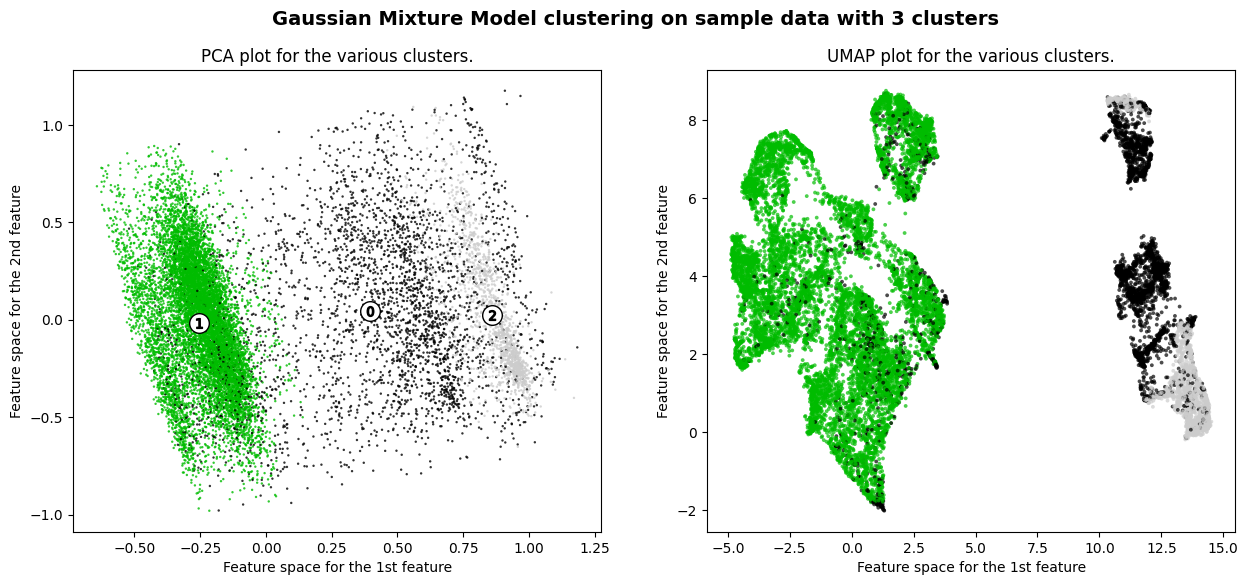

In [143]:
display_clustering(X, gmm3_clusters, title="Gaussian Mixture Model clustering on sample data with 3 clusters", figsize=(15,6))

#####  3 clusters is the maximum we can get with the Gaussian Mixture Model. Otherwise we are just splitting the big cluster into a mess

In [159]:
# Get the means of each cluster
data['cluster_3'] = gmm3_clusters
data[numerical_features + ['cluster_3'] + binary_features].groupby('cluster_3').mean().T.style.background_gradient(axis=1)

### 2.5. Results

<img src="../Results/Simple_clustering/kmeans_3_plot.png"/>
<img src="../Results/Simple_clustering/ms_4_plot.png"/>
<img src="../Results/Simple_clustering/kmeans_4_plot.png"/>
<img src="../Results/Simple_clustering/gmm_3_plot.png"/>
<img src="../Results/Simple_clustering/dbscan_3_plot.png"/>

The KMeans algorithm with 4 clusters seems to be the best option. 